<a href="https://colab.research.google.com/github/suriya-mouli/Alzheimer-s_Disease_Prediction/blob/main/Alzheimer's_Swin_T.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [ ]:
# Let's first see the exact structure of your dataset
import os

dataset_path = "/content/drive/MyDrive/Research Pape(Alzheimer's disease)/augmented__ADNI"

print(" Directory structure:")
items = os.listdir(dataset_path)
for item in items:
    item_path = os.path.join(dataset_path, item)
    if os.path.isdir(item_path):
        files = os.listdir(item_path)
        image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif', '.webp'))]
        print(f" {item}/ - {len(image_files)} images")

        # Check if this is the models folder
        if item.lower() == 'models':
            print(f" This is the models folder (contains {len(files)} .h5 files) - will be excluded")
    else:
        print(f" {item}")

 Directory structure:
 VeryMildDemented/ - 3500 images
 NonDemented/ - 3500 images
 ModerateDemented/ - 3500 images
 MildDemented/ - 3500 images


In [ ]:
# Solution 1: Create a custom ImageFolder that excludes the 'models' folder
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

class FilteredImageFolder(ImageFolder):
    def __init__(self, root, transform=None, exclude_folders=None):
        if exclude_folders is None:
            exclude_folders = ['models']
        self.exclude_folders = exclude_folders
        super().__init__(root, transform=transform)

    def find_classes(self, directory):
        """Override find_classes to exclude specific folders"""
        classes = sorted(entry.name for entry in os.scandir(directory)
                        if entry.is_dir() and entry.name not in self.exclude_folders)

        if not classes:
            raise FileNotFoundError(f"Couldn't find any valid class folders in {directory}. "
                                  f"Excluded folders: {self.exclude_folders}")

        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

# Now try loading with the filtered ImageFolder
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print(" Loading dataset with FilteredImageFolder (excluding 'models' folder)...")

try:
    dataset = FilteredImageFolder(root=dataset_path, transform=transform, exclude_folders=['models'])
    print(" SUCCESS! Dataset loaded successfully!")
    print(f"Dataset size: {len(dataset)} images")
    print(f"Number of classes: {len(dataset.classes)}")
    print(f"Classes: {dataset.classes}")
    print(f"Class to index mapping: {dataset.class_to_idx}")

except Exception as e:
    print(f" Error: {e}")

 Loading dataset with FilteredImageFolder (excluding 'models' folder)...
 SUCCESS! Dataset loaded successfully!
Dataset size: 14000 images
Number of classes: 4
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Class to index mapping: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [ ]:
# Now let's use whichever method worked to load the dataset
# First, try the FilteredImageFolder (Solution 1)
try:
    dataset = FilteredImageFolder(root=dataset_path, transform=transform, exclude_folders=['models'])
    print(" Using FilteredImageFolder")
except:
    # Fall back to Custom Dataset (Solution 3)
    try:
        dataset = CustomAlzheimerDataset(root_dir=dataset_path, transform=transform, exclude_folders=['models'])
        print(" Using CustomAlzheimerDataset")
    except Exception as e:
        print(f" All methods failed: {e}")
        raise

print(f"\nDataset successfully loaded!")
print(f"Total images: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Class names: {dataset.classes}")
print(f"Class to index mapping: {dataset.class_to_idx}")

 Using FilteredImageFolder

Dataset successfully loaded!
Total images: 14000
Number of classes: 4
Class names: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Class to index mapping: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [ ]:
# Now continue with the original training code
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import timm
import torch

# Calculate dataset sizes
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

print(f"✅ Dataset split completed!")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(dataset.classes)}")

✅ Dataset split completed!
Training samples: 9800
Validation samples: 2100
Test samples: 2100
Number of classes: 4


In [ ]:
# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created:")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

DataLoaders created:
Number of training batches: 307
Number of validation batches: 66
Number of test batches: 66


In [ ]:
# Initialize Swin-T model
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

# Load pre-trained Swin-T model
model = timm.create_model('swin_tiny_patch4_window7_224',
                         pretrained=True,
                         num_classes=num_classes)

model = model.to(device)

# Print model summary
print("Swin-T Model Architecture:")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Number of classes: 4


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Swin-T Model Architecture:
Number of parameters: 27,522,430


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

print("Loss function: CrossEntropyLoss")
print("Optimizer: AdamW")
print("Learning rate scheduler: CosineAnnealingLR")

Loss function: CrossEntropyLoss
Optimizer: AdamW
Learning rate scheduler: CosineAnnealingLR


In [ ]:
# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(dataloader, desc='Training')

    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct_predictions/total_predictions:.2f}%'
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100. * correct_predictions / total_predictions

    return epoch_loss, epoch_accuracy

In [ ]:
# Validation function
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation')

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calculate metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Store predictions and labels for later metrics
            probabilities = torch.softmax(outputs, dim=1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct_predictions/total_predictions:.2f}%'
            })

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100. * correct_predictions / total_predictions

    return epoch_loss, epoch_accuracy, all_predictions, all_labels, all_probabilities

In [ ]:
# Training loop for 30 epochs
from tqdm import tqdm
import numpy as np

num_epochs = 30

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Starting training for {} epochs...".format(num_epochs))
print("-" * 50)

best_val_accuracy = 0.0
best_model_state = None

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training phase
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation phase
    val_loss, val_accuracy, _, _, _ = validate_epoch(model, val_loader, criterion, device)

    # Update learning rate
    scheduler.step()

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict().copy()
        print(f"New best model saved with validation accuracy: {best_val_accuracy:.2f}%")

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_accuracy:.2f}%")

Starting training for 30 epochs...
--------------------------------------------------

Epoch 1/30


Validation: 100%|██████████| 66/66 [09:30<00:00,  8.64s/it, Loss=0.5442, Acc=79.14%]


Train Loss: 0.7725, Train Acc: 64.49%
Val Loss: 0.4718, Val Acc: 79.14%
New best model saved with validation accuracy: 79.14%

Epoch 2/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.64it/s, Loss=0.2296, Acc=89.43%]


Train Loss: 0.4018, Train Acc: 82.83%
Val Loss: 0.2778, Val Acc: 89.43%
New best model saved with validation accuracy: 89.43%

Epoch 3/30


Validation: 100%|██████████| 66/66 [00:19<00:00,  3.46it/s, Loss=0.2973, Acc=82.90%]


Train Loss: 0.2156, Train Acc: 91.83%
Val Loss: 0.4352, Val Acc: 82.90%

Epoch 4/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, Loss=0.5103, Acc=86.86%]


Train Loss: 0.1408, Train Acc: 94.90%
Val Loss: 0.3749, Val Acc: 86.86%

Epoch 5/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, Loss=0.5078, Acc=93.38%]


Train Loss: 0.0805, Train Acc: 96.98%
Val Loss: 0.2070, Val Acc: 93.38%
New best model saved with validation accuracy: 93.38%

Epoch 6/30


Validation: 100%|██████████| 66/66 [00:17<00:00,  3.67it/s, Loss=0.1230, Acc=94.14%]


Train Loss: 0.0545, Train Acc: 98.01%
Val Loss: 0.1991, Val Acc: 94.14%
New best model saved with validation accuracy: 94.14%

Epoch 7/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, Loss=0.3770, Acc=90.43%]


Train Loss: 0.0412, Train Acc: 98.57%
Val Loss: 0.3287, Val Acc: 90.43%

Epoch 8/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, Loss=0.6351, Acc=92.90%]


Train Loss: 0.0548, Train Acc: 98.14%
Val Loss: 0.2572, Val Acc: 92.90%

Epoch 9/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, Loss=0.2935, Acc=92.29%]


Train Loss: 0.0334, Train Acc: 98.86%
Val Loss: 0.2996, Val Acc: 92.29%

Epoch 10/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.64it/s, Loss=0.3221, Acc=91.33%]


Train Loss: 0.0276, Train Acc: 99.03%
Val Loss: 0.2872, Val Acc: 91.33%

Epoch 11/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s, Loss=0.6893, Acc=94.48%]


Train Loss: 0.0218, Train Acc: 99.23%
Val Loss: 0.2985, Val Acc: 94.48%
New best model saved with validation accuracy: 94.48%

Epoch 12/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.57it/s, Loss=0.3396, Acc=93.76%]


Train Loss: 0.0148, Train Acc: 99.55%
Val Loss: 0.2557, Val Acc: 93.76%

Epoch 13/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.66it/s, Loss=0.7049, Acc=95.00%]


Train Loss: 0.0191, Train Acc: 99.37%
Val Loss: 0.2543, Val Acc: 95.00%
New best model saved with validation accuracy: 95.00%

Epoch 14/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, Loss=0.6451, Acc=94.14%]


Train Loss: 0.0142, Train Acc: 99.45%
Val Loss: 0.2640, Val Acc: 94.14%

Epoch 15/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.64it/s, Loss=0.7360, Acc=95.52%]


Train Loss: 0.0237, Train Acc: 99.21%
Val Loss: 0.2076, Val Acc: 95.52%
New best model saved with validation accuracy: 95.52%

Epoch 16/30


Validation: 100%|██████████| 66/66 [00:17<00:00,  3.67it/s, Loss=0.8258, Acc=94.81%]


Train Loss: 0.0086, Train Acc: 99.67%
Val Loss: 0.2937, Val Acc: 94.81%

Epoch 17/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, Loss=0.6057, Acc=94.86%]


Train Loss: 0.0094, Train Acc: 99.67%
Val Loss: 0.2362, Val Acc: 94.86%

Epoch 18/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, Loss=1.0124, Acc=91.67%]


Train Loss: 0.0070, Train Acc: 99.74%
Val Loss: 0.3910, Val Acc: 91.67%

Epoch 19/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s, Loss=1.0326, Acc=95.81%]


Train Loss: 0.0049, Train Acc: 99.82%
Val Loss: 0.2142, Val Acc: 95.81%
New best model saved with validation accuracy: 95.81%

Epoch 20/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s, Loss=0.9369, Acc=95.76%]


Train Loss: 0.0028, Train Acc: 99.92%
Val Loss: 0.2475, Val Acc: 95.76%

Epoch 21/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.60it/s, Loss=0.7355, Acc=95.00%]


Train Loss: 0.0071, Train Acc: 99.72%
Val Loss: 0.2151, Val Acc: 95.00%

Epoch 22/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s, Loss=0.9111, Acc=95.90%]


Train Loss: 0.0035, Train Acc: 99.89%
Val Loss: 0.2253, Val Acc: 95.90%
New best model saved with validation accuracy: 95.90%

Epoch 23/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s, Loss=0.6653, Acc=95.86%]


Train Loss: 0.0019, Train Acc: 99.92%
Val Loss: 0.1962, Val Acc: 95.86%

Epoch 24/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s, Loss=0.8165, Acc=95.90%]


Train Loss: 0.0014, Train Acc: 99.93%
Val Loss: 0.2276, Val Acc: 95.90%

Epoch 25/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, Loss=0.9141, Acc=96.14%]


Train Loss: 0.0023, Train Acc: 99.92%
Val Loss: 0.2204, Val Acc: 96.14%
New best model saved with validation accuracy: 96.14%

Epoch 26/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.57it/s, Loss=0.9565, Acc=96.14%]


Train Loss: 0.0014, Train Acc: 99.98%
Val Loss: 0.2185, Val Acc: 96.14%

Epoch 27/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s, Loss=1.0217, Acc=96.19%]


Train Loss: 0.0007, Train Acc: 99.98%
Val Loss: 0.2342, Val Acc: 96.19%
New best model saved with validation accuracy: 96.19%

Epoch 28/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, Loss=1.0087, Acc=96.43%]


Train Loss: 0.0004, Train Acc: 100.00%
Val Loss: 0.2240, Val Acc: 96.43%
New best model saved with validation accuracy: 96.43%

Epoch 29/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, Loss=0.9738, Acc=96.33%]


Train Loss: 0.0008, Train Acc: 99.97%
Val Loss: 0.2164, Val Acc: 96.33%

Epoch 30/30


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, Loss=0.9731, Acc=96.38%]

Train Loss: 0.0008, Train Acc: 99.98%
Val Loss: 0.2157, Val Acc: 96.38%

Training completed!
Best validation accuracy: 96.43%


In [ ]:
# Load best model for testing
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model for testing")

Loaded best model for testing


In [ ]:
# Comprehensive evaluation on test set
def evaluate_model(model, test_loader, criterion, device, class_names):
    model.eval()

    all_predictions = []
    all_labels = []
    all_probabilities = []
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    test_loss /= len(test_loader)

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)

    return test_loss, all_predictions, all_labels, all_probabilities

# Run evaluation
test_loss, test_predictions, test_labels, test_probabilities = evaluate_model(
    model, test_loader, criterion, device, dataset.classes
)

Testing: 100%|██████████| 66/66 [09:30<00:00,  8.64s/it]


In [22]:
# Calculate all required metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("\n" + "="*50)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*50)

# Basic accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)

# Precision, Recall, F1-Score (macro averaged)
precision = precision_score(test_labels, test_predictions, average='macro', zero_division=0)
recall = recall_score(test_labels, test_predictions, average='macro', zero_division=0)
f1 = f1_score(test_labels, test_predictions, average='macro', zero_division=0)

# Confusion Matrix
cm = confusion_matrix(test_labels, test_predictions)

# ROC-AUC (for multi-class)
try:
    if len(dataset.classes) == 2:  # Binary classification
        roc_auc = roc_auc_score(test_labels, test_probabilities[:, 1])
    else:  # Multi-class classification
        roc_auc = roc_auc_score(test_labels, test_probabilities, multi_class='ovr')
except:
    roc_auc = "Could not calculate"

# Log Loss
log_loss_value = log_loss(test_labels, test_probabilities)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc}")
print(f"Log Loss: {log_loss_value:.4f}")

# Print class-wise metrics
print("\nClass-wise Metrics:")
class_precision = precision_score(test_labels, test_predictions, average=None, zero_division=0)
class_recall = recall_score(test_labels, test_predictions, average=None, zero_division=0)
class_f1 = f1_score(test_labels, test_predictions, average=None, zero_division=0)

for i, class_name in enumerate(dataset.classes):
    print(f"{class_name}: Precision={class_precision[i]:.4f}, Recall={class_recall[i]:.4f}, F1={class_f1[i]:.4f}")


COMPREHENSIVE MODEL EVALUATION
Test Loss: 0.2113
Test Accuracy: 0.9681 (96.81%)
Precision: 0.9684
Recall: 0.9684
F1-Score: 0.9682
ROC-AUC: 0.9969072255335677
Log Loss: 0.2044

Class-wise Metrics:
MildDemented: Precision=0.9392, Recall=0.9789, F1=0.9586
ModerateDemented: Precision=0.9980, Recall=1.0000, F1=0.9990
NonDemented: Precision=0.9905, Recall=0.9580, F1=0.9740
VeryMildDemented: Precision=0.9457, Recall=0.9367, F1=0.9412



Generating plots...


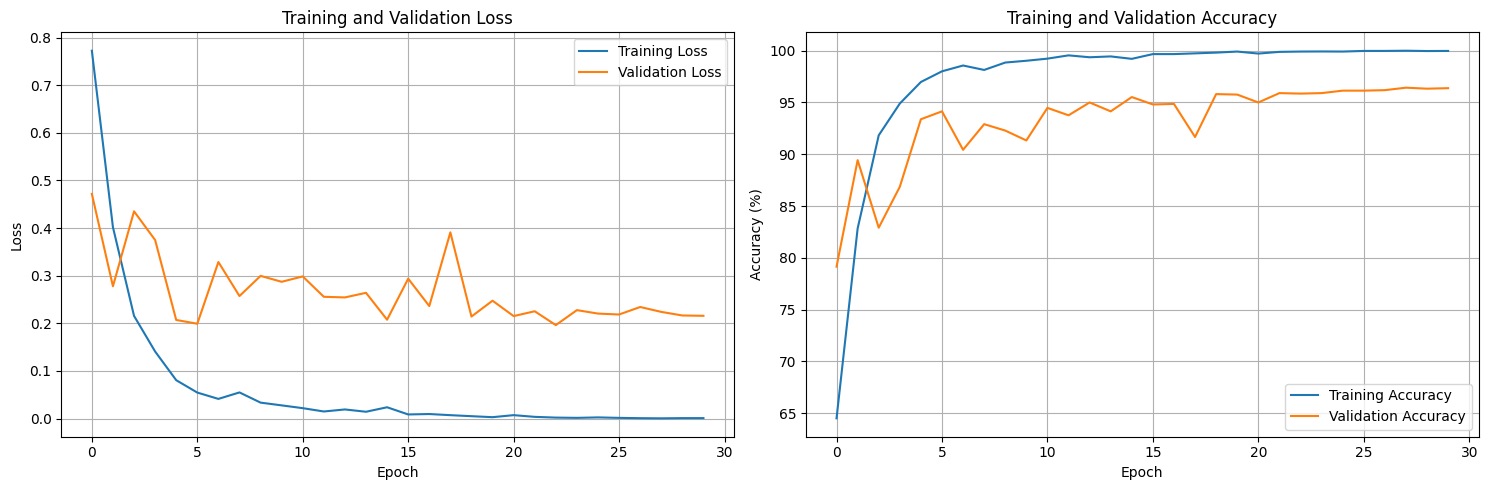

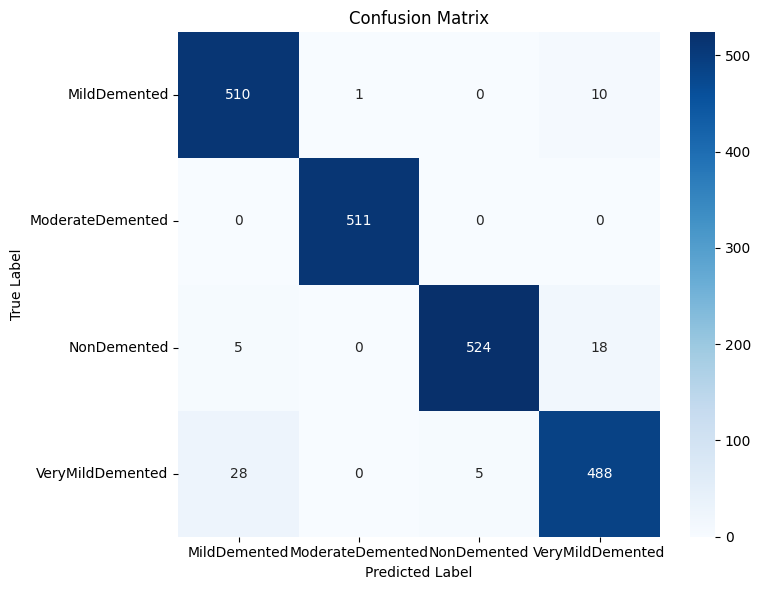

In [23]:
# Plotting functions
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Generate plots
print("\nGenerating plots...")
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)
plot_confusion_matrix(cm, dataset.classes)


Generating ROC-AUC Curve...


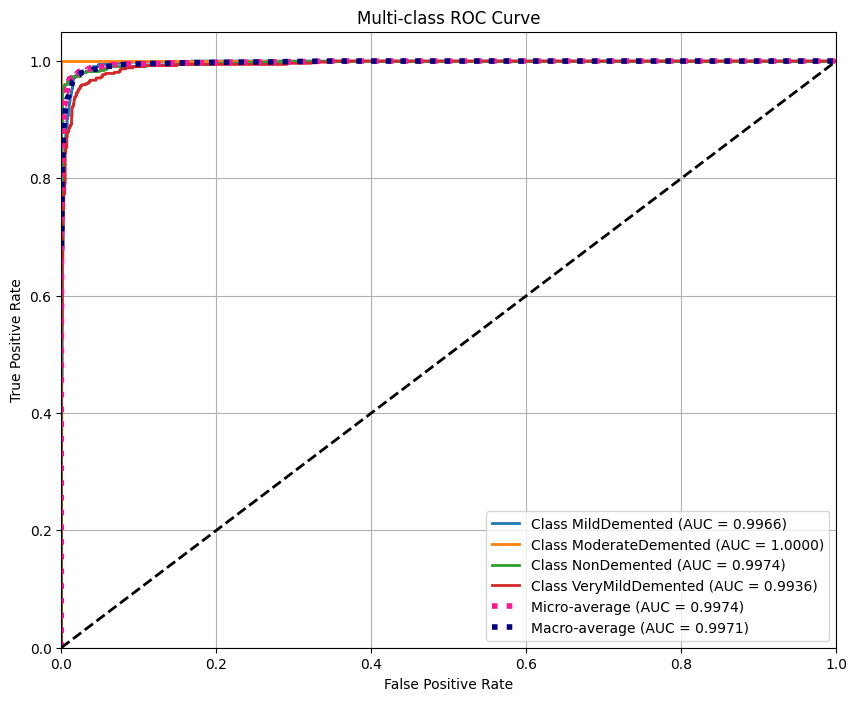


AUC Values for each class:
MildDemented: 0.9966
ModerateDemented: 1.0000
NonDemented: 0.9974
VeryMildDemented: 0.9936
Micro-average AUC: 0.9974
Macro-average AUC: 0.9971


In [ ]:
# Generate ROC-AUC curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_roc_auc_curve(test_labels, test_probabilities, class_names):
    # Binarize the labels for multi-class ROC
    if len(class_names) == 2:
        # Binary classification
        fpr, tpr, _ = roc_curve(test_labels, test_probabilities[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Binary Classification')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    else:
        # Multi-class classification
        # Binarize the labels
        y_test_bin = label_binarize(test_labels, classes=range(len(class_names)))

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        plt.figure(figsize=(10, 8))

        for i in range(len(class_names)):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_probabilities[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2,
                    label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.4f})')

        # Plot micro-average ROC curve
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), test_probabilities.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        plt.plot(fpr["micro"], tpr["micro"],
                label=f'Micro-average (AUC = {roc_auc["micro"]:.4f})',
                color='deeppink', linestyle=':', linewidth=4)

        # Plot macro-average ROC curve
        from itertools import cycle
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(class_names)):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= len(class_names)

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        plt.plot(fpr["macro"], tpr["macro"],
                label=f'Macro-average (AUC = {roc_auc["macro"]:.4f})',
                color='navy', linestyle=':', linewidth=4)

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Multi-class ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

        # Print AUC values
        print("\nAUC Values for each class:")
        for i, class_name in enumerate(class_names):
            print(f"{class_name}: {roc_auc[i]:.4f}")
        print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
        print(f"Macro-average AUC: {roc_auc['macro']:.4f}")

# Generate ROC-AUC curve
print("\nGenerating ROC-AUC Curve...")
plot_roc_auc_curve(test_labels, test_probabilities, dataset.classes)

In [ ]:
# First, import h5py
import h5py
import json

print("Saving in all recommended formats...")

# 1. ✅ CSV Files (ESSENTIAL for your thesis)
results_df = pd.DataFrame({
    'epoch': range(1, num_epochs + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,  # Fixed typo: was 'val_losses'
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies
})
results_df.to_csv('swin_t_training_history.csv', index=False)

# Save final metrics
final_metrics_dict = {
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': roc_auc if isinstance(roc_auc, float) else str(roc_auc),
    'log_loss': log_loss_value
}

final_metrics = pd.DataFrame([final_metrics_dict])
final_metrics.to_csv('swin_t_final_metrics.csv', index=False)

print("✅ CSV files saved:")
print("   - swin_t_training_history.csv")
print("   - swin_t_final_metrics.csv")

Saving in all recommended formats...
✅ CSV files saved:
   - swin_t_training_history.csv
   - swin_t_final_metrics.csv


In [ ]:
# 2. ✅ PyTorch .pth format (BEST for PyTorch)
import torch
torch.save(
    {
        'model_state_dict': model.state_dict(),
        'class_names': dataset.classes,
        'class_to_idx': dataset.class_to_idx,
        'test_metrics': final_metrics_dict
    },
    'swin_t_alzheimer_model.pth'
)

print("✅ PyTorch model saved: swin_t_alzheimer_model.pth")

✅ PyTorch model saved: swin_t_alzheimer_model.pth


In [ ]:
# 3. ✅ H5 format (for compatibility)
def save_complete_model_to_h5(model, file_path, class_names, class_to_idx, metrics):
    with h5py.File(file_path, 'w') as f:
        # Save model weights
        weights_group = f.create_group('model_weights')
        for name, param in model.named_parameters():
            weights_group.create_dataset(name, data=param.data.cpu().numpy())

        # Save metadata
        info_group = f.create_group('metadata')
        info_group.create_dataset('class_names', data=json.dumps(class_names))
        info_group.create_dataset('class_to_idx', data=json.dumps(class_to_idx))
        info_group.create_dataset('test_accuracy', data=metrics['test_accuracy'])
        info_group.create_dataset('precision', data=metrics['precision'])
        info_group.create_dataset('recall', data=metrics['recall'])
        info_group.create_dataset('f1_score', data=metrics['f1_score'])

    print(f"✅ H5 model saved to {file_path}")

# Save H5 format
save_complete_model_to_h5(model, 'swin_t_alzheimer_model.h5',
                         dataset.classes, dataset.class_to_idx,
                         final_metrics_dict)

print("🎯 All formats saved successfully!")

✅ H5 model saved to swin_t_alzheimer_model.h5
🎯 All formats saved successfully!


In [ ]:
# Verify all files were created
import os

print("\n📁 Verification - All saved files:")
saved_files = [
    'swin_t_training_history.csv',
    'swin_t_final_metrics.csv',
    'swin_t_alzheimer_model.pth',
    'swin_t_alzheimer_model.h5'
]

for file in saved_files:
    if os.path.exists(file):
        file_size = os.path.getsize(file) / (1024 * 1024)  # Size in MB
        print(f"   ✅ {file} - {file_size:.2f} MB")
    else:
        print(f"   ❌ {file} - Not found")


📁 Verification - All saved files:
   ✅ swin_t_training_history.csv - 0.00 MB
   ✅ swin_t_final_metrics.csv - 0.00 MB
   ✅ swin_t_alzheimer_model.pth - 105.06 MB
   ✅ swin_t_alzheimer_model.h5 - 105.07 MB


In [ ]:
# Display a summary of your results for quick reference
print("\n📊 QUICK RESULTS SUMMARY FOR THESIS:")
print("="*50)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc}")
print(f"Number of Classes: {len(dataset.classes)}")
print(f"Classes: {dataset.classes}")
print(f"Total Training Images: {len(dataset)}")
print("="*50)


📊 QUICK RESULTS SUMMARY FOR THESIS:
Test Accuracy: 0.9681 (96.81%)
Precision: 0.9684
Recall: 0.9684
F1-Score: 0.9682
ROC-AUC: 0.9969072255335677
Number of Classes: 4
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Total Training Images: 14000
